# Introduction

In this notebook we use Google's Tensorflow library to classify the type of the tumor as malignant or benign knowing its characteristics.


## Importing Libraries

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.models import Model

from scipy import stats


## The data

### Reading the data

Reading the dataset into a Pandas Dataframe Object

In [52]:
data = pd.read_csv("breast-cancer.csv")

In [53]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Cleaning the data

#### Handling Null Values

The dataset has no null values as seen:

In [54]:
data.isna().sum().max()

0

#### Handling Categorical values

The `diagnosis` column is categorical, not numeric. So the next step is to convert it to numeric by replacing 'M' with 1 and 'B' with 0 using `pd.replace`. 

In [55]:
data.replace(['M', 'B'],
             [1, 0], inplace=True)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


#### Handling Outliers

Remove outliers that have z score higher than 3 or lower than -3 

In [37]:
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]


In [38]:
data.shape

(487, 32)

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. We will use the test set in the final evaluation of the model.

In [56]:
train_dataset = data.sample(frac=0.8, random_state=0)
test_dataset = data.drop(train_dataset.index)


In [57]:
train_dataset.shape

(455, 32)

### Split features from labels
Separate the target value —the diagnosis, also called the label— from the features. This label is the value that we will train the model to classify.

In [58]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('diagnosis')
test_labels = test_features.pop('diagnosis')


In [59]:
train_features.shape

(455, 31)

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [60]:
train_dataset[['radius_mean', 'texture_mean', 'perimeter_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean']].describe().transpose()[['mean', 'std']]

,mean,std
radius_mean,14.038009,3.443339
texture_mean,19.254352,4.356593
perimeter_mean,91.345407,23.756012
smoothness_mean,0.096414,0.014029
compactness_mean,0.103311,0.052823
concavity_mean,0.087379,0.080251


It is good practice to normalize features that have different ranges.

If we skip normalizing the features, the model will still converge (ie: reach the optimum loss), However, normalization makes training much more stable.

### The Normalization layer

The tf.keras.layers.Normalization is a clean and simple way to add feature normalization into the model.

The first step is to create the layer:

In [61]:
normalizer = tf.keras.layers.Normalization(axis=-1)


Then, fit the state of the preprocessing layer to the data by calling Normalization.adapt:

In [62]:
normalizer.adapt(np.array(train_features))

When the layer is called, it returns the input data, with each feature independently normalized:

In [63]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())


First example: [[915691.       13.4      20.52     88.64    556.7       0.11      0.15
       0.14      0.08      0.21      0.07      0.39      0.93      3.09
      33.67      0.01      0.02      0.03      0.01      0.02      0.
      16.41     29.66    113.3     844.4       0.16      0.39      0.51
       0.21      0.36      0.11]]

Normalized: [[-0.23 -0.19  0.29 -0.11 -0.26  1.01  0.83  0.71  0.88  1.09  1.44 -0.04
  -0.52  0.13 -0.14 -0.56 -0.15  0.08  0.24 -0.44  0.07  0.06  0.66  0.22
  -0.03  1.1   0.88  1.16  1.41  1.08  1.55]]


## Classification

### Building the Neural Network Model

We first declare the layers of the neural network and their activation functions.


In [64]:
model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])


We then config the model with losses and metrics that we want using `model.compile()`

In [65]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


We then trains the model on the training data for a fixed number of epochs (iterations).

In [66]:
r = model.fit(train_features, train_labels, validation_data=(test_features, test_labels), epochs=100)


Epoch 1/100
15/15 [==============================] - 1s 12ms/step - loss: 0.6924 - accuracy: 0.5604 - val_loss: 0.6255 - val_accuracy: 0.7544
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 0.5739 - accuracy: 0.8703 - val_loss: 0.5255 - val_accuracy: 0.8947
Epoch 3/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4891 - accuracy: 0.9209 - val_loss: 0.4472 - val_accuracy: 0.9298
Epoch 4/100
15/15 [==============================] - 0s 3ms/step - loss: 0.4189 - accuracy: 0.9297 - val_loss: 0.3790 - val_accuracy: 0.9298
Epoch 5/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3572 - accuracy: 0.9253 - val_loss: 0.3204 - val_accuracy: 0.9298
Epoch 6/100
15/15 [==============================] - 0s 3ms/step - loss: 0.3045 - accuracy: 0.9319 - val_loss: 0.2725 - val_accuracy: 0.9474
Epoch 7/100
15/15 [==============================] - 0s 3ms/step - loss: 0.2621 - accuracy: 0.9341 - val_loss: 0.2336 - val_accuracy: 0.9474
Epoch 8/100


## Model Evaluation

`model.fit` returns a history object which contains the loss and accuracy of the model at each epoch. So now we can use this object to plot accuracy across time so as to get a better understanding of the model's performance.


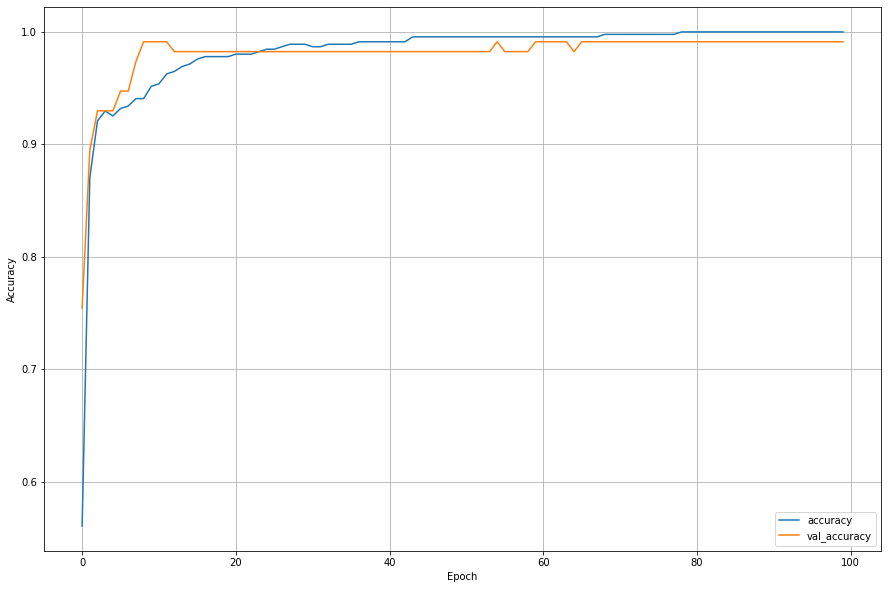

In [67]:
def plot_loss(history):
    plt.figure(figsize=(15, 10))
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_loss(r)

## Make predictions
With the model trained, we now use it to make predictions about the type of the tumor. We attach a softmax layer to convert the model's output to probabilities, which are easier to interpret.

In [68]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])


We let the model predict the clarity of the test set:

In [69]:
predictions = probability_model.predict(test_features)


4/4 [==============================] - 0s 1ms/step


We take a look at the first prediction:

In [70]:
predictions[0]


array([0., 1.], dtype=float32)

The prediction is an array of 2 numbers. They represent the model's "confidence" that the tumor type corresponds to each of the 2 different types.

In [71]:
np.argmax(predictions[0])


1

In [72]:
type_labels = ['Benign', 'Malignant']

type_labels[np.argmax(predictions[0])]


'Malignant'

## Review Performance

To get an overview of the model's performance, we print the confusion matrix of the predicted labels. This shows us how many labels did the model classify correctly and how many did he miss.

In [73]:

predicted = np.argmax(predictions, axis=1)
predicted.shape

confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])
print(confusion_matrix)


Predicted   0   1
Actual           
0          69   1
1           0  44


Now let's visualise the confusion matrix:

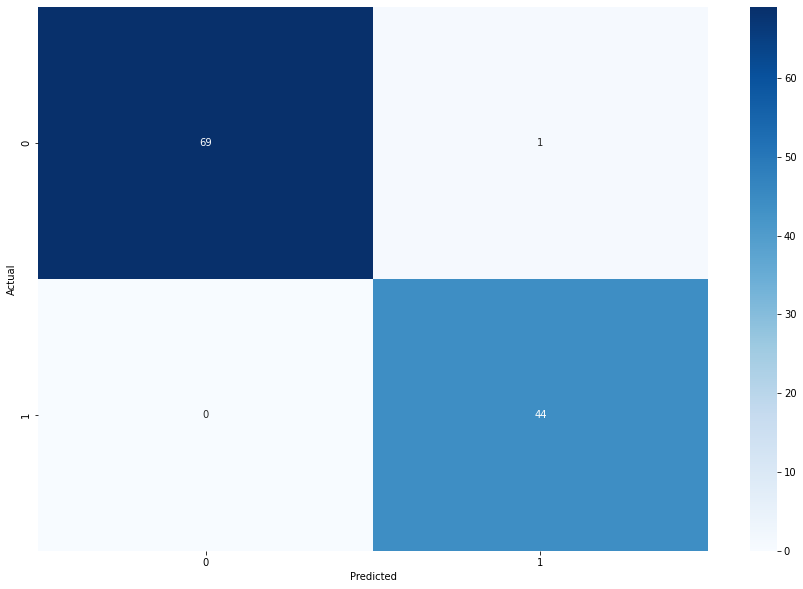

In [74]:

confusion_matrix = pd.crosstab(test_labels, predicted, rownames=[
                               'Actual'], colnames=['Predicted'])

plt.figure(figsize=(15, 10))
plt.ticklabel_format(style='plain')
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()


## Conclusion

We built a classifying deep neural network model to classify the tumor type using TensorFlow library. The model reached top accuracy of 99.12%. In the end we visualised the model's performance using the confusion matrix.